<a href="https://colab.research.google.com/github/aadilmufti/trafffic-sign-detection/blob/master/Traffic_Sign_Detection_with_IDSIA_MCDNN_no_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import os
import PIL
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.utils.data.sampler as sampler
from torch import nn, optim
import torch.nn.functional as F
import csv
from collections import defaultdict, namedtuple
import os
import shutil

import pandas as pd

from sklearn.metrics import confusion_matrix


%matplotlib inline

In [5]:
%%shell

cd gtsrb/
# apt install p7zip-full
# 7z x traffic-signs-data.zip
ls
# realpath signames.csv

test.p	traffic-signs-data.zip	train.p  valid.p


In [0]:
# Load pickled data
training_file = "gtsrb/train.p"
validation_file = "gtsrb/valid.p"
testing_file = "gtsrb/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']

In [11]:
# Number of training examples
n_train = len(X_train)
# Number of validation examples.
n_valid = len(X_valid)

# The shape of an traffic sign image
image_shape = X_train[0].shape[:-1]

# Number of unique classes/labels in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Image data shape = (32, 32)
Number of classes = 43


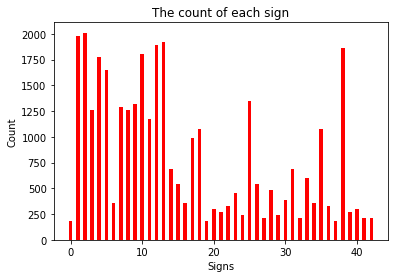

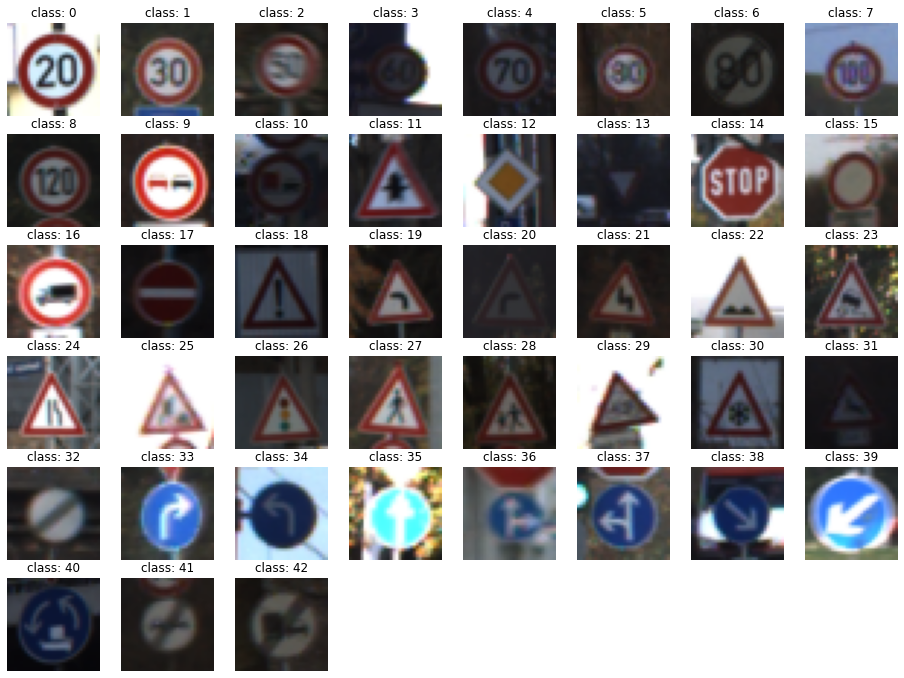

In [12]:
fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(y_train), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(X_train[i])

In [0]:
class PickledDataset(Dataset):
    def __init__(self, file_path, transform=None):
        with open(file_path, mode='rb') as f:
            data = pickle.load(f)
            self.features = data['features']
            self.labels = data['labels']
            self.count = len(self.labels)
            self.transform = transform
        
    def __getitem__(self, index):
        feature = self.features[index]
        if self.transform is not None:
            feature = self.transform(feature)
        return (feature, self.labels[index])

    def __len__(self):
        return self.count

In [0]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [15]:
torch.manual_seed(1)

In [0]:
train_dataset = PickledDataset(training_file, transform=transforms.ToTensor())
valid_dataset = PickledDataset(validation_file, transform=transforms.ToTensor())
test_dataset = PickledDataset(testing_file, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(x, y):
    return x.to(device), y.to(device, dtype=torch.int64)

train_loader = WrappedDataLoader(train_loader, to_device)
valid_loader = WrappedDataLoader(valid_loader, to_device)
test_loader = WrappedDataLoader(test_loader, to_device)

In [0]:
def loss_batch(model, loss_func, x, y, opt=None):
    output = model(x)
    loss = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), torch.sum(correct).item(), len(x)

In [0]:
def valid_batch(model, loss_func, x, y):
    output = model(x)
    loss = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)
    
    return loss.item(), torch.sum(correct).item(), len(x)

In [0]:
def evaluate(model, loss_func, dl):
    model.eval()
    with torch.no_grad():
        losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in dl])
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_accuracy = np.sum(corrects) / np.sum(nums) * 100
        
    print(f"Validation loss: {val_loss:.6f}\t"
          f"Validation accruacy: {val_accuracy:.3f}%")

In [0]:
model_path = 'gtsrb/model.pt'

In [0]:
def trainer(epochs, model, loss_func, opt, train_dl, valid_dl, patience=10):
    wait = 0
    valid_loss_min = np.Inf
    data_dict = np.zeros((epochs,4))
    for epoch in range(epochs):
        # Train model
        model.train()
        losses, corrects, nums = zip(*[loss_batch(model, loss_func, x, y, opt) for x, y in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        train_accuracy = np.sum(corrects) / np.sum(nums) * 100

        # Validation model
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in valid_dl])
            valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            valid_accuracy = np.sum(corrects) / np.sum(nums) * 100
            data_dict[epoch] = np.array([train_loss, train_accuracy, valid_loss, valid_accuracy])
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Train loss: {train_loss:.6f}\t"
                  f"Train accruacy: {train_accuracy:.3f}%\t",
                  f"Validation loss: {valid_loss:.6f}\t",
                  f"Validation accruacy: {valid_accuracy:.3f}%")
            # Save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...")
                torch.save(model.state_dict(), model_path)
                valid_loss_min = valid_loss
                wait = 0
            # Early stopping
            else:
                wait += 1
                if wait >= patience:
                    print(f"Terminated Training for Early Stopping at Epoch {epoch+1}")
                    return data_dict
    return data_dict

In [0]:
#using the IDSIA MCDNN model architecture

class TrafficSignNet(nn.Module):
    def __init__(self):
        super(TrafficSignNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 100, 5)
        self.conv1_bn = nn.BatchNorm2d(100)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(100, 150, 3)
        self.conv2_bn = nn.BatchNorm2d(150)
        self.conv3 = nn.Conv2d(150, 250, 1)
        self.conv3_bn = nn.BatchNorm2d(250)
        self.fc1 = nn.Linear(250 * 3 * 3, 350)
        self.fc1_bn = nn.BatchNorm1d(350)
        self.fc2 = nn.Linear(350, 43)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.elu(self.conv1(x)))
        x = self.dropout(self.conv1_bn(x))
        x = self.pool(F.elu(self.conv2(x)))
        x = self.dropout(self.conv2_bn(x))
        x = self.pool(F.elu(self.conv3(x)))
        x = self.dropout(self.conv3_bn(x))
        x = x.view(-1, 250 * 3 * 3)
        x = F.elu(self.fc1(x))
        x = self.dropout(self.fc1_bn(x))
        x = self.fc2(x)
        return x

In [24]:
criterion = nn.CrossEntropyLoss()
n_epochs = 30

model = TrafficSignNet().to(device)
optimizer = optim.Adamax(model.parameters(), lr=0.0005)
data_dict_1 = trainer(n_epochs, model, criterion, optimizer, train_loader, valid_loader)

[Epoch 1/30] Train loss: 2.084193	Train accruacy: 43.958%	 Validation loss: 1.415320	 Validation accruacy: 58.957%
Validation loss decreased (inf --> 1.415320). Saving model...
[Epoch 2/30] Train loss: 1.035741	Train accruacy: 71.206%	 Validation loss: 0.822138	 Validation accruacy: 78.118%
Validation loss decreased (1.415320 --> 0.822138). Saving model...
[Epoch 3/30] Train loss: 0.644222	Train accruacy: 82.727%	 Validation loss: 0.495007	 Validation accruacy: 87.188%
Validation loss decreased (0.822138 --> 0.495007). Saving model...
[Epoch 4/30] Train loss: 0.441305	Train accruacy: 88.457%	 Validation loss: 0.356073	 Validation accruacy: 91.043%
Validation loss decreased (0.495007 --> 0.356073). Saving model...
[Epoch 5/30] Train loss: 0.334530	Train accruacy: 91.138%	 Validation loss: 0.276318	 Validation accruacy: 93.084%
Validation loss decreased (0.356073 --> 0.276318). Saving model...
[Epoch 6/30] Train loss: 0.270791	Train accruacy: 92.825%	 Validation loss: 0.236198	 Validatio

In [27]:
n_epochs = 100
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
data_dict_2 = trainer(n_epochs, model, criterion, optimizer, train_loader, valid_loader)

[Epoch 1/100] Train loss: 0.046884	Train accruacy: 98.727%	 Validation loss: 0.077043	 Validation accruacy: 98.005%
Validation loss decreased (inf --> 0.077043). Saving model...
[Epoch 2/100] Train loss: 0.041157	Train accruacy: 98.908%	 Validation loss: 0.080216	 Validation accruacy: 97.891%
[Epoch 3/100] Train loss: 0.045463	Train accruacy: 98.744%	 Validation loss: 0.078656	 Validation accruacy: 98.050%
[Epoch 4/100] Train loss: 0.043769	Train accruacy: 98.839%	 Validation loss: 0.080178	 Validation accruacy: 98.005%
[Epoch 5/100] Train loss: 0.042206	Train accruacy: 98.885%	 Validation loss: 0.084482	 Validation accruacy: 97.891%
[Epoch 6/100] Train loss: 0.042964	Train accruacy: 98.845%	 Validation loss: 0.079674	 Validation accruacy: 97.982%
[Epoch 7/100] Train loss: 0.042049	Train accruacy: 98.833%	 Validation loss: 0.078341	 Validation accruacy: 98.095%
[Epoch 8/100] Train loss: 0.044497	Train accruacy: 98.759%	 Validation loss: 0.080317	 Validation accruacy: 97.959%
[Epoch 9/1

In [28]:
#verifying accuracy on validation set 
check_point = torch.load(model_path, map_location=device)
model.load_state_dict(check_point)
evaluate(model, criterion, valid_loader)

Validation loss: 0.077043	Validation accruacy: 98.005%


Text(0.5, 1.0, 'val_accuracy')

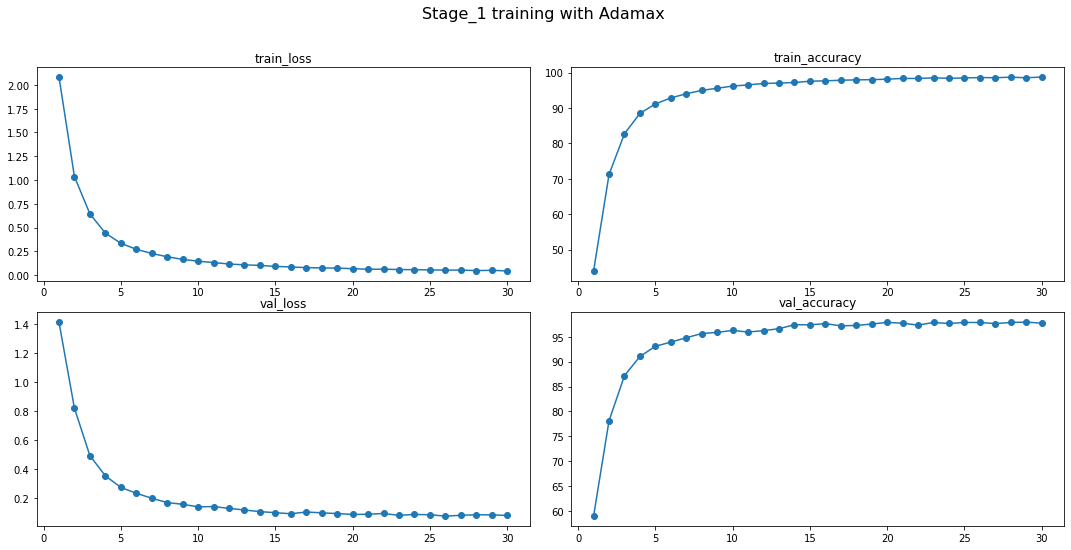

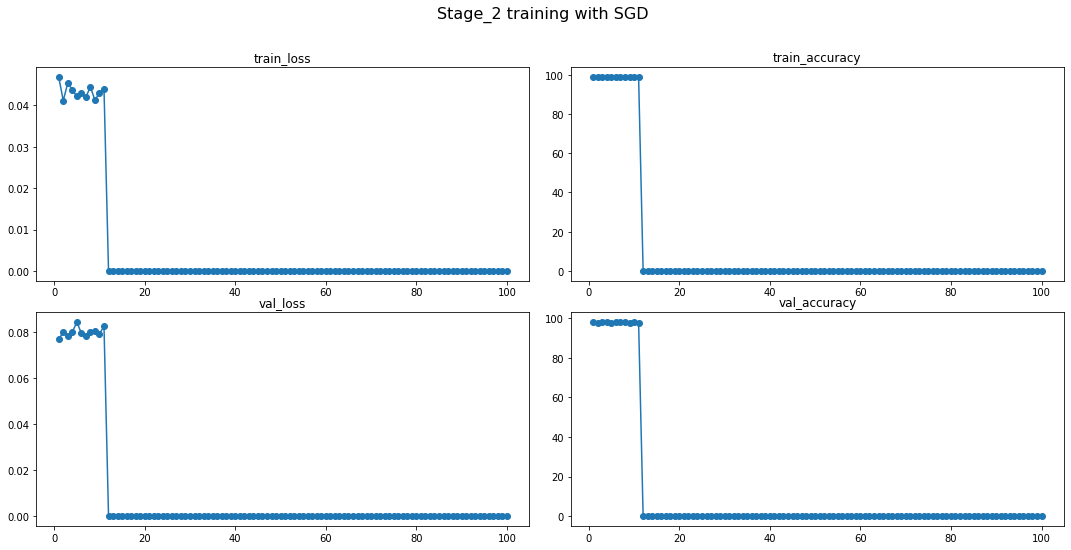

In [29]:
x_value_1 = np.arange(len(data_dict_1)) + 1
y_value_1 = data_dict_1.T

fig_1, axs_1 = plt.subplots(2, 2, figsize=(15,8))
fig_1.suptitle('Stage_1 training with Adamax', fontsize=16)
fig_1.tight_layout(rect=[0, 0.03, 1, 0.9])
axs_1[0][0].plot(x_value_1, y_value_1[0], 'o-')
axs_1[0][0].set_title('train_loss')

axs_1[0][1].plot(x_value_1, y_value_1[1], 'o-')
axs_1[0][1].set_title('train_accuracy')

axs_1[1][0].plot(x_value_1, y_value_1[2], 'o-')
axs_1[1][0].set_title('val_loss')

axs_1[1][1].plot(x_value_1, y_value_1[3], 'o-')
axs_1[1][1].set_title('val_accuracy')


x_value_2 = np.arange(len(data_dict_2)) + 1
y_value_2 = data_dict_2.T

fig_2, axs_2 = plt.subplots(2, 2, figsize=(15,8))
fig_2.suptitle('Stage_2 training with SGD', fontsize=16)
fig_2.tight_layout(rect=[0, 0.03, 1, 0.9])
axs_2[0][0].plot(x_value_2, y_value_2[0], 'o-')
axs_2[0][0].set_title('train_loss')

axs_2[0][1].plot(x_value_2, y_value_2[1], 'o-')
axs_2[0][1].set_title('train_accuracy')

axs_2[1][0].plot(x_value_2, y_value_2[2], 'o-')
axs_2[1][0].set_title('val_loss')

axs_2[1][1].plot(x_value_2, y_value_2[3], 'o-')
axs_2[1][1].set_title('val_accuracy')

In [30]:
check_point = torch.load(model_path, map_location=device)
model.load_state_dict(check_point)
evaluate(model, criterion, test_loader)

Validation loss: 0.102026	Validation accruacy: 97.039%
